## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.python.training import moving_averages
from tensorflow.python.ops import control_flow_ops
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 16.78 and accuracy of 0.1719
Iteration 100: with minibatch training loss = 1.058 and accuracy of 0.2188
Iteration 200: with minibatch training loss = 0.8991 and accuracy of 0.2969
Iteration 300: with minibatch training loss = 0.6398 and accuracy of 0.3125
Iteration 400: with minibatch training loss = 0.5932 and accuracy of 0.2656
Iteration 500: with minibatch training loss = 0.6597 and accuracy of 0.3281
Iteration 600: with minibatch training loss = 0.5186 and accuracy of 0.3438
Iteration 700: with minibatch training loss = 0.4387 and accuracy of 0.4062
Epoch 1, Overall loss = 0.806 and accuracy of 0.2903


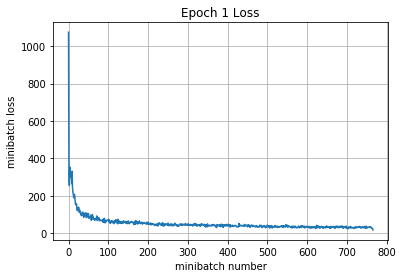

Validation
Epoch 1, Overall loss = 0.4382 and accuracy of 0.368


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    # move shuffle to each epoch
    # np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    total_losses = []
    total_accuracies = []
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        np.random.shuffle(train_indicies)
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.4g} and accuracy of {2:.4g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.4g} and accuracy of {1:.4g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses and epochs <= 20:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        total_losses.append(total_loss)
        total_accuracies.append(total_correct)
    if plot_losses and len(total_losses) > 1 and len(total_accuracies) > 1:
        plt.grid(True)
        plt.title('Result')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim(0,3)
        plt.plot(total_losses, label='loss')
        plt.show()
        plt.grid(True)
        plt.title('Result')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim(0.4,1)
        plt.plot(total_accuracies, label='accuracy')
        plt.show()
    return total_loss,total_correct

with tf.Session(config=config) as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32],
                             initializer=tf.truncated_normal_initializer(stddev=0.01))
    bconv1 = tf.get_variable("bconv1", shape=[32], initializer=tf.constant_initializer(0.1))
    moving_mean1 = tf.get_variable('moving_mean1', shape=[32], initializer=tf.zeros_initializer, trainable=False)
    moving_var1 = tf.get_variable('moving_var1', shape=[32], initializer=tf.ones_initializer, trainable=False)
    gamma1 = tf.get_variable("gamma1", shape=[32], initializer=tf.ones_initializer)
    beta1 = tf.get_variable("beta1", shape=[32], initializer=tf.zeros_initializer)
    W2 = tf.get_variable("W2", shape=[5408, 1024],
                             initializer=tf.truncated_normal_initializer(stddev=0.01))
    b2 = tf.get_variable("b2", shape=[1024], initializer=tf.constant_initializer(0.1))
    W3 = tf.get_variable("W3", shape=[1024, 10],
                             initializer=tf.truncated_normal_initializer(stddev=0.01))
    b3 = tf.get_variable("b3", shape=[10], initializer=tf.zeros_initializer)

    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    relu1 = tf.nn.relu(conv1)

    mean, variance = tf.nn.moments(conv1, axes=[0,1,2])
    update_moving_mean = moving_averages.assign_moving_average(moving_mean1, mean, 0.99)
    update_moving_variance = moving_averages.assign_moving_average(moving_var1, variance, 0.99)
    tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_mean)
    tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_variance)
    mean1, var1 = control_flow_ops.cond(is_training, lambda: (mean, variance), lambda: (moving_mean1, moving_var1))

    bn1 = tf.nn.batch_normalization(relu1, mean=mean1, variance=var1, offset=beta1, scale=gamma1, variance_epsilon=1e-5)
    pool1 = tf.nn.max_pool(bn1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    flat1 = tf.reshape(pool1,[-1,5408])
    fc2 = tf.matmul(flat1,W2) + b2
    relu2 = tf.nn.relu(fc2)
    y_out = tf.matmul(relu2,W3) + b3
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session(config=config) as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

1.53 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session(config=config) as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

1.54 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)




In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.314 and accuracy of 0.125
Iteration 100: with minibatch training loss = 2.052 and accuracy of 0.1875
Iteration 200: with minibatch training loss = 1.995 and accuracy of 0.25
Iteration 300: with minibatch training loss = 1.834 and accuracy of 0.375
Iteration 400: with minibatch training loss = 1.343 and accuracy of 0.5156
Iteration 500: with minibatch training loss = 1.414 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.388 and accuracy of 0.4531
Iteration 700: with minibatch training loss = 1.361 and accuracy of 0.5
Epoch 1, Overall loss = 1.616 and accuracy of 0.4222


(1.6163608194078718, 0.42222448979591837)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.295 and accuracy of 0.534


(1.2950451412200927, 0.53400000000000003)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [12]:
## Feel free to play with this cell

def conv(X, name, shape, strides=[1,1,1,1], padding='SAME', act=tf.nn.relu, use_bn=True, is_training=False, weight_decay=0.0005):
    out = None
    with tf.variable_scope("scope"):
        W = tf.get_variable("%s/W"%name, shape=shape,
                            initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False),
                            regularizer=tf.contrib.layers.l2_regularizer(weight_decay))
        if not use_bn:
            b = tf.get_variable("%s/b"%name, shape=(shape[-1]), initializer=tf.constant_initializer(0.1))
        if use_bn:
            global_mean = tf.get_variable("%s/global_mean"%name, shape=(shape[-1]), initializer=tf.zeros_initializer, trainable=False)
            global_var = tf.get_variable("%s/global_var"%name, shape=(shape[-1]), initializer=tf.ones_initializer, trainable=False)
            gamma = tf.get_variable("%s/gamma"%name, shape=(shape[-1]), initializer=tf.ones_initializer)
            beta = tf.get_variable("%s/beta"%name, shape=(shape[-1]), initializer=tf.zeros_initializer)

        conv = tf.nn.conv2d(X, W, strides=strides, padding=padding)
        if not use_bn:
            conv = conv + b
        if act==None:
            act = tf.identity
        if use_bn:
            mean, var = tf.nn.moments(conv, axes=[0,1,2])
            update_moving_mean = moving_averages.assign_moving_average(global_mean, mean, 0.999)
            update_moving_var = moving_averages.assign_moving_average(global_var, var, 0.999)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_mean)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_var)
            mean, vare = control_flow_ops.cond(is_training, lambda: (mean, var), lambda: (global_mean, global_var))
            bn = tf.nn.batch_normalization(conv, mean=mean, variance=var, offset=beta, scale=gamma, variance_epsilon=1e-5)
            out = act(bn)
        else:
            out = act(conv)
    return out

def fc(X, name, shape, act=tf.nn.relu, use_bn=True, is_training=False, weight_decay=0.0005):
    out = None
    with tf.variable_scope("scope"):
        W = tf.get_variable("%s/W"%name, shape=shape,
                            initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False),
                            regularizer=tf.contrib.layers.l2_regularizer(weight_decay))
        if not use_bn:
            b = tf.get_variable("%s/b"%name, shape=(shape[-1]), initializer=tf.constant_initializer(0.1))
        if use_bn:
            global_mean = tf.get_variable("%s/global_mean"%name, shape=(shape[-1]), initializer=tf.zeros_initializer, trainable=False)
            global_var = tf.get_variable("%s/global_var"%name, shape=(shape[-1]), initializer=tf.ones_initializer, trainable=False)
            gamma = tf.get_variable("%s/gamma"%name, shape=(shape[-1]), initializer=tf.ones_initializer)
            beta = tf.get_variable("%s/beta"%name, shape=(shape[-1]), initializer=tf.zeros_initializer)

        fc = tf.matmul(X,W)
        if not use_bn:
            fc = fc + b
        if act==None:
            act = tf.identity
        if use_bn:
            mean, var = tf.nn.moments(fc, axes=[0])
            update_moving_mean = moving_averages.assign_moving_average(global_mean, mean, 0.999)
            update_moving_var = moving_averages.assign_moving_average(global_var, var, 0.999)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_mean)
            tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_var)
            mean, vare = control_flow_ops.cond(is_training, lambda: (mean, var), lambda: (global_mean, global_var))
            bn = tf.nn.batch_normalization(fc, mean=mean, variance=var, offset=beta, scale=gamma, variance_epsilon=1e-5)
            out = act(bn)
        else:
            out = act(fc)
    return out

def preprocess(X):
    shape = tf.shape(X)
    batch_size, height, width, channel = shape[0], shape[1], shape[2], shape[3]
    image = tf.transpose(X, [1, 2, 3, 0])
    image = tf.reshape(image, [height, width, channel*batch_size])
    image = tf.image.random_flip_left_right(image)
    image = tf.reshape(image, [height, width, channel, batch_size])
    image = tf.transpose(image, [3, 0, 1, 2])
    image = tf.random_crop(image, size=[batch_size, 28, 28, channel])
    image = tf.image.resize_images(image, (height, width))
    return image

def my_model(X,y,is_training):
    image = control_flow_ops.cond(is_training, lambda: preprocess(X), lambda: X)
    image = image / 127.5
    conv1 = conv(image, name="conv1", shape=[3,3,3,32], strides=[1,1,1,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv2 = conv(conv1, name="conv2", shape=[3,3,32,32], strides=[1,2,2,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv3 = conv(conv2, name="conv3", shape=[3,3,32,64], strides=[1,1,1,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv4 = conv(conv3, name="conv4", shape=[3,3,64,64], strides=[1,2,2,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv5 = conv(conv4, name="conv5", shape=[3,3,64,128], strides=[1,1,1,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv6 = conv(conv5, name="conv6", shape=[3,3,128,128], strides=[1,2,2,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv7 = conv(conv6, name="conv7", shape=[3,3,128,256], strides=[1,1,1,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv8 = conv(conv7, name="conv8", shape=[3,3,256,256], strides=[1,1,1,1], padding='SAME', act=tf.nn.leaky_relu, use_bn=True, is_training=is_training)
    conv9 = conv(conv8, name="conv9", shape=[1,1,256,10], strides=[1,1,1,1], padding='SAME', act=tf.identity, use_bn=False, is_training=is_training)
    pool9 = tf.nn.avg_pool(conv9, ksize=[1,4,4,1], strides=[1,4,4,1], padding='VALID')
    y_out = tf.reshape(pool9,[-1,10])
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cross_entropy_mean = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out))
mean_loss = tf.add_n([cross_entropy_mean] + regularization_losses)
global_step = tf.Variable(0, trainable=False)

starter_learning_rate = 1e-1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           49000, 0.1, staircase=True)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)

Training
Iteration 0: with minibatch training loss = 2.963 and accuracy of 0.1
Epoch 1, Overall loss = 1.911 and accuracy of 0.4621
Iteration 490: with minibatch training loss = 1.716 and accuracy of 0.57
Epoch 2, Overall loss = 1.439 and accuracy of 0.6103
Iteration 980: with minibatch training loss = 1.354 and accuracy of 0.57
Epoch 3, Overall loss = 1.218 and accuracy of 0.6738
Iteration 1470: with minibatch training loss = 1.052 and accuracy of 0.68
Epoch 4, Overall loss = 1.106 and accuracy of 0.7075
Iteration 1960: with minibatch training loss = 1.056 and accuracy of 0.71
Epoch 5, Overall loss = 1.031 and accuracy of 0.7293
Iteration 2450: with minibatch training loss = 0.8495 and accuracy of 0.81
Epoch 6, Overall loss = 0.9961 and accuracy of 0.7374
Iteration 2940: with minibatch training loss = 1.142 and accuracy of 0.72
Epoch 7, Overall loss = 0.9642 and accuracy of 0.7519
Iteration 3430: with minibatch training loss = 0.8972 and accuracy of 0.77
Epoch 8, Overall loss = 0.9484

Epoch 64, Overall loss = 0.8556 and accuracy of 0.8205
Iteration 31360: with minibatch training loss = 0.9036 and accuracy of 0.81
Epoch 65, Overall loss = 0.8637 and accuracy of 0.815
Iteration 31850: with minibatch training loss = 0.7696 and accuracy of 0.84
Epoch 66, Overall loss = 0.8559 and accuracy of 0.8179
Iteration 32340: with minibatch training loss = 0.7396 and accuracy of 0.85
Epoch 67, Overall loss = 0.8615 and accuracy of 0.8167
Iteration 32830: with minibatch training loss = 0.8693 and accuracy of 0.8
Epoch 68, Overall loss = 0.8654 and accuracy of 0.8149
Iteration 33320: with minibatch training loss = 0.9508 and accuracy of 0.76
Epoch 69, Overall loss = 0.8594 and accuracy of 0.8174
Iteration 33810: with minibatch training loss = 0.9478 and accuracy of 0.79
Epoch 70, Overall loss = 0.8644 and accuracy of 0.8153
Iteration 34300: with minibatch training loss = 1.026 and accuracy of 0.76
Epoch 71, Overall loss = 0.8641 and accuracy of 0.8157
Iteration 34790: with minibatch

Epoch 127, Overall loss = 0.3703 and accuracy of 0.9288
Iteration 62230: with minibatch training loss = 0.2781 and accuracy of 0.96
Epoch 128, Overall loss = 0.3658 and accuracy of 0.9311
Iteration 62720: with minibatch training loss = 0.3434 and accuracy of 0.94
Epoch 129, Overall loss = 0.3626 and accuracy of 0.9317
Iteration 63210: with minibatch training loss = 0.3191 and accuracy of 0.94
Epoch 130, Overall loss = 0.3606 and accuracy of 0.9323
Iteration 63700: with minibatch training loss = 0.4019 and accuracy of 0.89
Epoch 131, Overall loss = 0.3585 and accuracy of 0.9312
Iteration 64190: with minibatch training loss = 0.3225 and accuracy of 0.94
Epoch 132, Overall loss = 0.3517 and accuracy of 0.9347
Iteration 64680: with minibatch training loss = 0.2694 and accuracy of 0.96
Epoch 133, Overall loss = 0.3599 and accuracy of 0.9328
Iteration 65170: with minibatch training loss = 0.3489 and accuracy of 0.94
Epoch 134, Overall loss = 0.3568 and accuracy of 0.9315
Iteration 65660: wit

Epoch 190, Overall loss = 0.3316 and accuracy of 0.9459
Iteration 93100: with minibatch training loss = 0.3567 and accuracy of 0.94
Epoch 191, Overall loss = 0.3293 and accuracy of 0.9459
Iteration 93590: with minibatch training loss = 0.3403 and accuracy of 0.93
Epoch 192, Overall loss = 0.3337 and accuracy of 0.9448
Iteration 94080: with minibatch training loss = 0.3005 and accuracy of 0.97
Epoch 193, Overall loss = 0.3347 and accuracy of 0.9442
Iteration 94570: with minibatch training loss = 0.3812 and accuracy of 0.94
Epoch 194, Overall loss = 0.3318 and accuracy of 0.9457
Iteration 95060: with minibatch training loss = 0.2992 and accuracy of 0.97
Epoch 195, Overall loss = 0.3279 and accuracy of 0.9469
Iteration 95550: with minibatch training loss = 0.4147 and accuracy of 0.92
Epoch 196, Overall loss = 0.3305 and accuracy of 0.9459
Iteration 96040: with minibatch training loss = 0.3088 and accuracy of 0.95
Epoch 197, Overall loss = 0.3331 and accuracy of 0.9447
Iteration 96530: wit

Epoch 253, Overall loss = 0.1637 and accuracy of 0.9955
Iteration 123970: with minibatch training loss = 0.1492 and accuracy of 1
Epoch 254, Overall loss = 0.1637 and accuracy of 0.9949
Iteration 124460: with minibatch training loss = 0.2039 and accuracy of 0.97
Epoch 255, Overall loss = 0.1622 and accuracy of 0.9955
Iteration 124950: with minibatch training loss = 0.1603 and accuracy of 1
Epoch 256, Overall loss = 0.162 and accuracy of 0.9956
Iteration 125440: with minibatch training loss = 0.1457 and accuracy of 1
Epoch 257, Overall loss = 0.1607 and accuracy of 0.9953
Iteration 125930: with minibatch training loss = 0.1486 and accuracy of 1
Epoch 258, Overall loss = 0.1609 and accuracy of 0.9951
Iteration 126420: with minibatch training loss = 0.1724 and accuracy of 0.99
Epoch 259, Overall loss = 0.1592 and accuracy of 0.9958
Iteration 126910: with minibatch training loss = 0.1426 and accuracy of 1
Epoch 260, Overall loss = 0.1574 and accuracy of 0.996
Iteration 127400: with minibat

Epoch 316, Overall loss = 0.1269 and accuracy of 0.9981
Iteration 154840: with minibatch training loss = 0.1218 and accuracy of 1
Epoch 317, Overall loss = 0.1265 and accuracy of 0.9984
Iteration 155330: with minibatch training loss = 0.122 and accuracy of 1
Epoch 318, Overall loss = 0.1259 and accuracy of 0.9986
Iteration 155820: with minibatch training loss = 0.1279 and accuracy of 1
Epoch 319, Overall loss = 0.1268 and accuracy of 0.9982
Iteration 156310: with minibatch training loss = 0.12 and accuracy of 1
Epoch 320, Overall loss = 0.1264 and accuracy of 0.9982
Iteration 156800: with minibatch training loss = 0.1296 and accuracy of 1
Epoch 321, Overall loss = 0.1266 and accuracy of 0.9981
Iteration 157290: with minibatch training loss = 0.1278 and accuracy of 1
Epoch 322, Overall loss = 0.1263 and accuracy of 0.9982
Iteration 157780: with minibatch training loss = 0.1187 and accuracy of 1
Epoch 323, Overall loss = 0.1263 and accuracy of 0.9981
Iteration 158270: with minibatch trai

Epoch 379, Overall loss = 0.122 and accuracy of 0.9987
Iteration 185710: with minibatch training loss = 0.117 and accuracy of 1
Epoch 380, Overall loss = 0.122 and accuracy of 0.9987
Iteration 186200: with minibatch training loss = 0.1277 and accuracy of 0.99
Epoch 381, Overall loss = 0.1224 and accuracy of 0.9983
Iteration 186690: with minibatch training loss = 0.1298 and accuracy of 1
Epoch 382, Overall loss = 0.122 and accuracy of 0.9989
Iteration 187180: with minibatch training loss = 0.1186 and accuracy of 1
Epoch 383, Overall loss = 0.1214 and accuracy of 0.9989
Iteration 187670: with minibatch training loss = 0.1202 and accuracy of 1
Epoch 384, Overall loss = 0.1221 and accuracy of 0.9986
Iteration 188160: with minibatch training loss = 0.1162 and accuracy of 1
Epoch 385, Overall loss = 0.1215 and accuracy of 0.9989
Iteration 188650: with minibatch training loss = 0.116 and accuracy of 1
Epoch 386, Overall loss = 0.1218 and accuracy of 0.9987
Iteration 189140: with minibatch tra

Epoch 442, Overall loss = 0.1202 and accuracy of 0.999
Iteration 216580: with minibatch training loss = 0.1207 and accuracy of 1
Epoch 443, Overall loss = 0.12 and accuracy of 0.9991
Iteration 217070: with minibatch training loss = 0.1146 and accuracy of 1
Epoch 444, Overall loss = 0.1211 and accuracy of 0.9985
Iteration 217560: with minibatch training loss = 0.1172 and accuracy of 1
Epoch 445, Overall loss = 0.121 and accuracy of 0.9986
Iteration 218050: with minibatch training loss = 0.1162 and accuracy of 1
Epoch 446, Overall loss = 0.1199 and accuracy of 0.999
Iteration 218540: with minibatch training loss = 0.1211 and accuracy of 1
Epoch 447, Overall loss = 0.1198 and accuracy of 0.9991
Iteration 219030: with minibatch training loss = 0.1181 and accuracy of 1
Epoch 448, Overall loss = 0.1205 and accuracy of 0.999
Iteration 219520: with minibatch training loss = 0.1143 and accuracy of 1
Epoch 449, Overall loss = 0.1206 and accuracy of 0.9989
Iteration 220010: with minibatch trainin

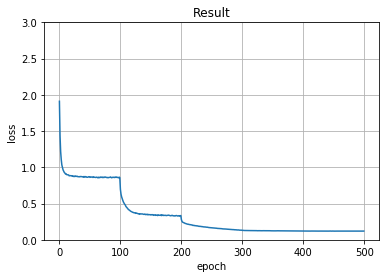

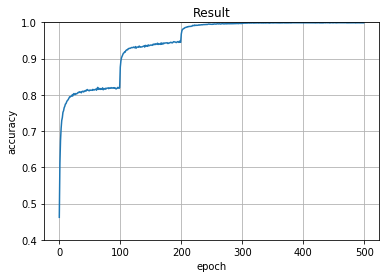

Validation
Epoch 1, Overall loss = 0.4644 and accuracy of 0.907


(0.46442643702030184, 0.90700000000000003)

In [13]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,500,100,490,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,100)

In [14]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,100)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,100)

Training
Epoch 1, Overall loss = 0.1325 and accuracy of 0.9938
Validation
Epoch 1, Overall loss = 0.4521 and accuracy of 0.911


(0.45210490226745603, 0.91100000000000003)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

- A fully convolutional network with 9 conv layers and no fc layers.
- The structure of each conv layer is conv-bn-act.
- Only using 1x1 and 3x3 size of convolution kernels to reduce size of parameters.
- Using stride 2 convolution instead of max pooling.
- Using leaky relu as activation function.
- Using Kaiming initializer.
- Using L2 weight decay regularization.
- Using data augmentation including left and right flipping and random croping to avoid overfitting.
- Using SGD with momentum to optimize the network.
- Decaying the learning rate to 1/10, when every time the loss function is slow and concussion, 
- The final accuracy on test sets is 90.0%.

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [15]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,100)

Test
Epoch 1, Overall loss = 0.5255 and accuracy of 0.9006


(0.52553233176469805, 0.90059999999999996)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.